## PCA Visualization of Combined Datasets\n"
                      "This notebook loads two datasets:\n"
                      "1. A multi-class folder of `.npy` files (each file is one class).\n"
                      "2. A single `.npy` file (all samples share one new class label).\n\n"
                      "It then performs PCA to reduce each sample to 2D and plots them, "
                      "coloring points by their class label.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from helper import MultiNpyFilesDataset, SingleNpyDataset
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# ── Configuration ────────────────────────────────────────────────
# Path to the folder containing multiple .npy files (one file = one class)
multi_dir = '../ResData/wavefake128_2048split/train/fake'

# Path to the single .npy file whose samples share a new class label
single_npy = '../ResData/wavefake128_2048split/train/real.npy'
# ── Load datasets ────────────────────

#!/usr/bin/env python3
"""
Compare multiple dimensionality-reduction methods with progress bars.
For each method, we plot three scatter plots:
  1. Combined dataset (multi-file + single-file)
  2. Multi-file dataset only
  3. Single-file dataset only
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
import umap
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from tqdm import tqdm

from helper import MultiNpyFilesDataset, SingleNpyDataset

# ── LOAD & FLATTEN DATASETS ─────────────────────────────────────
ds_multi    = MultiNpyFilesDataset(dir_path=multi_dir)
existing_labels = [lbl for _, _, lbl in ds_multi.samples]
new_label       = max(existing_labels) + 1
ds_single   = SingleNpyDataset(npy_file=single_npy, label=new_label)
ds_combined = ConcatDataset([ds_multi, ds_single])

def load_Xy(ds):
    loader = DataLoader(ds, batch_size=len(ds), shuffle=False)
    x_batch, y_batch = next(iter(loader))
    X = x_batch.view(x_batch.size(0), -1).numpy()
    y = y_batch.numpy()
    return X, y

X_comb, y_comb     = load_Xy(ds_combined)
X_multi, y_multi   = load_Xy(ds_multi)
X_single, y_single = load_Xy(ds_single)

# ── LABEL → NAME MAPS ──────────────────────────────────────────
filenames = sorted(f for f in os.listdir(multi_dir) if f.endswith('.npy'))
file_label_map = {i: os.path.splitext(f)[0] for i, f in enumerate(filenames)}

label_names_comb   = {
    i: file_label_map.get(i, os.path.splitext(os.path.basename(single_npy))[0])
    for i in np.unique(y_comb)
}
label_names_multi  = {i: file_label_map[i] for i in np.unique(y_multi)}
label_names_single = {new_label: os.path.splitext(os.path.basename(single_npy))[0]}

# ── PLOTTING HELPER ────────────────────────────────────────────
def plot_2d(X2, y, label_names, title):
    unique = np.unique(y)
    cmap = cm.get_cmap('tab10')
    norm = mcolors.Normalize(vmin=unique.min(), vmax=unique.max())

    plt.figure(figsize=(15, 10))
    for i in unique:
        mask = (y == i)
        plt.scatter(
            X2[mask, 0], X2[mask, 1],
            label=label_names[i],
            alpha=0.3,
            s=20,
            color=cmap(norm(i)),
            edgecolor='none'
        )
    plt.legend(title="Class")
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

2025-07-03 22:26:05.062520: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 22:26:05.071323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751556365.081897 2964398 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751556365.084948 2964398 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751556365.094404 2964398 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

PCA:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_2959241/4099083783.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


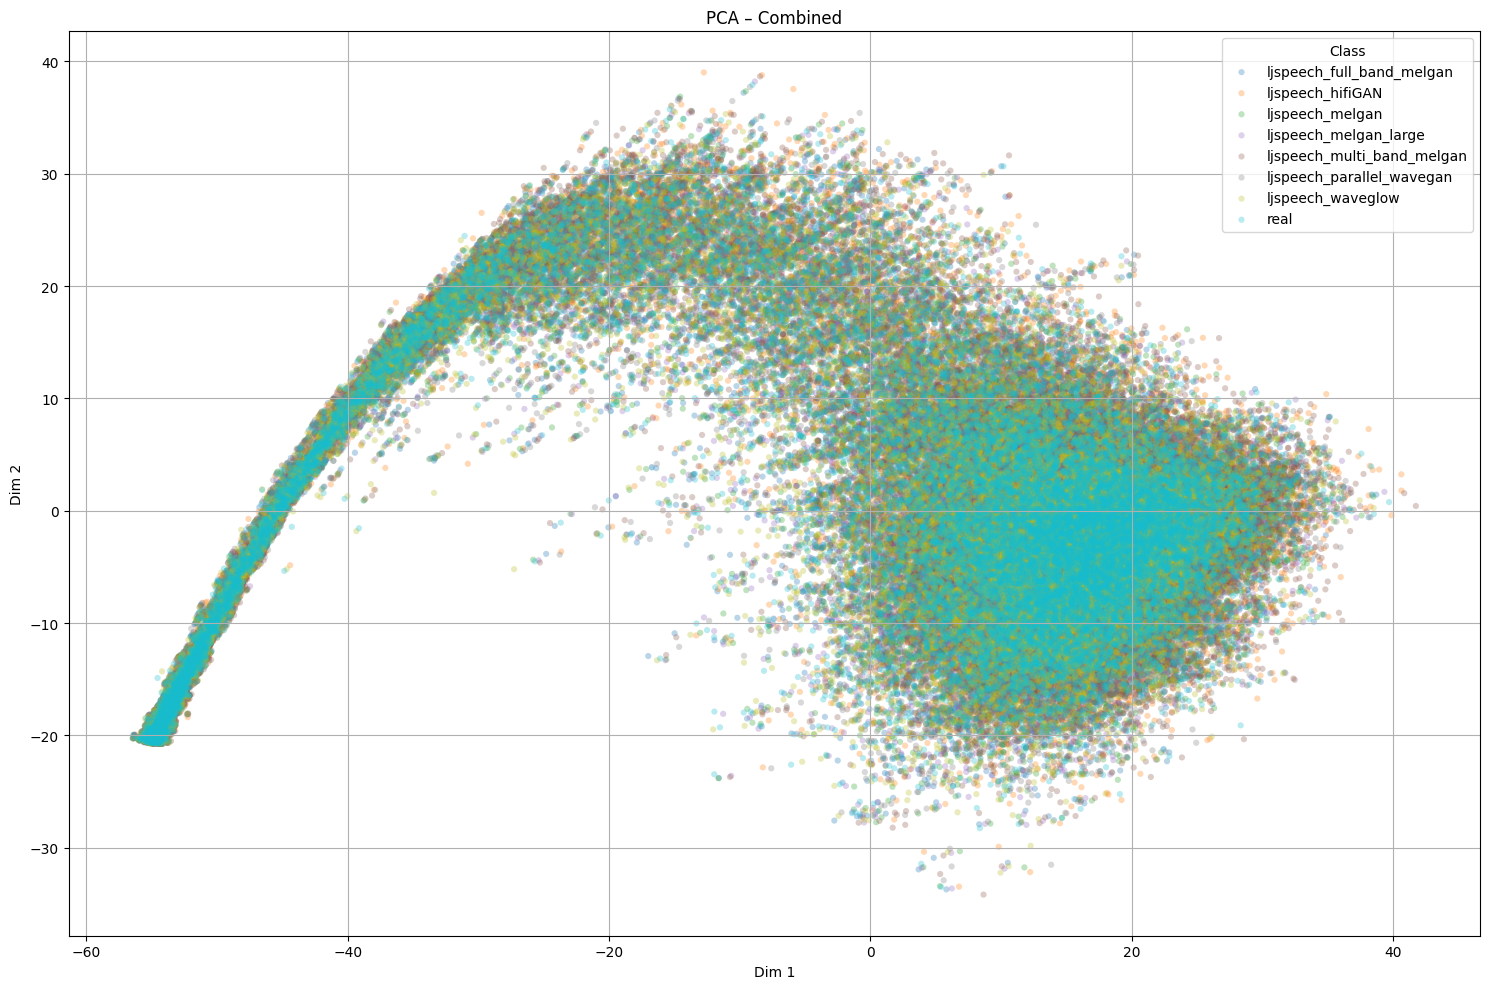

PCA:  33%|███▎      | 1/3 [00:16<00:32, 16.03s/it]/tmp/ipykernel_2959241/4099083783.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


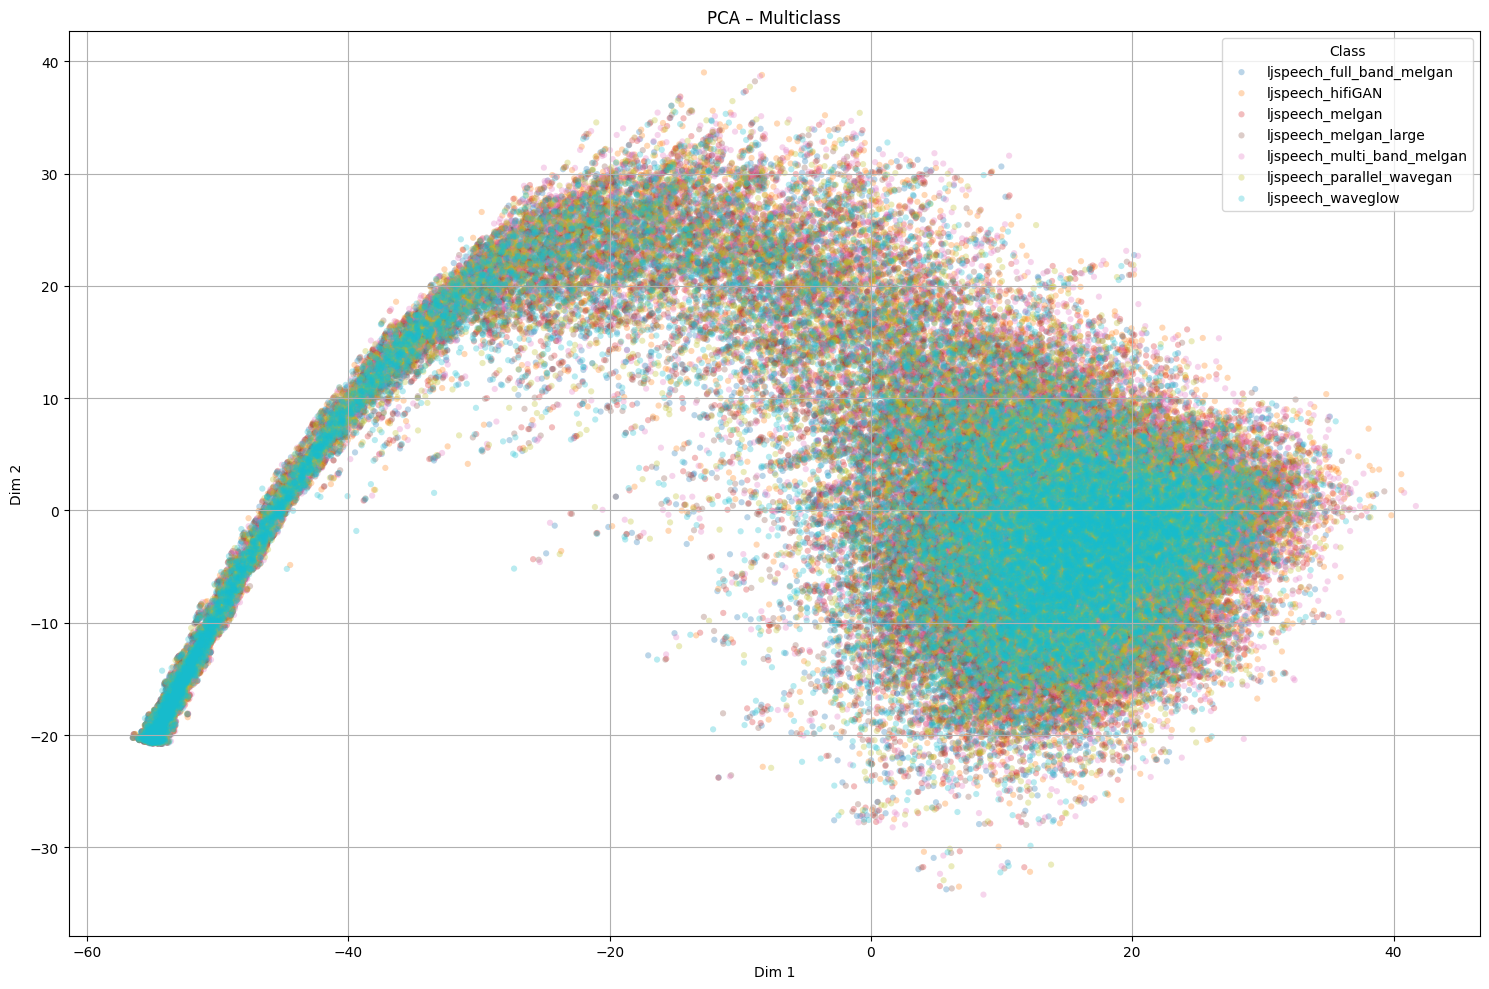

PCA:  67%|██████▋   | 2/3 [00:29<00:14, 14.74s/it]/tmp/ipykernel_2959241/4099083783.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


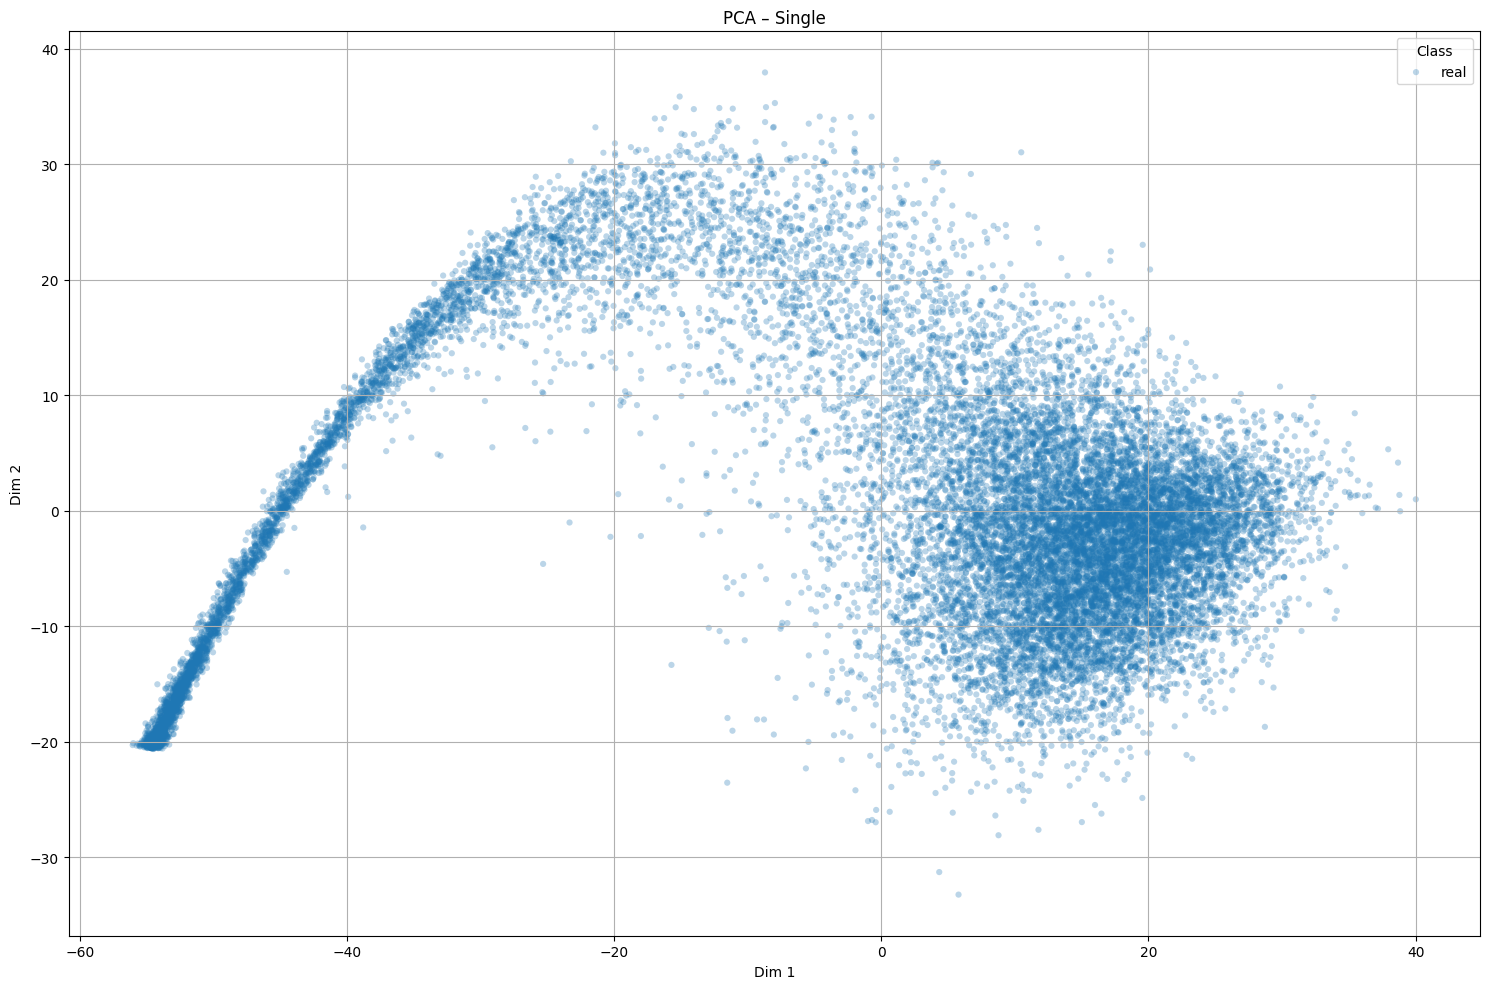

PCA: 100%|██████████| 3/3 [00:32<00:00, 10.84s/it]


In [2]:

# ── 1) PCA ───────────────────────────────────────────────────────
pca = PCA(n_components=2, svd_solver='randomized')
for name, (X, y, ln) in tqdm({
    "Combined":   (X_comb,   y_comb,   label_names_comb),
    "Multiclass": (X_multi,  y_multi,  label_names_multi),
    "Single":     (X_single, y_single, label_names_single),
}.items(), desc="PCA"):
    X2 = pca.fit_transform(X)
    plot_2d(X2, y, ln, f"PCA – {name}")


In [ ]:
# ── 2) t-SNE ────────────────────────────────────────────────────
tsne = TSNE(
    n_components=10,
    perplexity=30,
    init='pca',
    learning_rate='auto',
    n_iter=250,
    random_state=42
)
for name, (X, y, ln) in tqdm({
    "Combined":   (X_comb,   y_comb,   label_names_comb),
    "Multiclass": (X_multi,  y_multi,  label_names_multi),
    "Single":     (X_single, y_single, label_names_single),
}.items(), desc="t-SNE"):
    X2 = tsne.fit_transform(X)
    plot_2d(X2, y, ln, f"t-SNE – {name}")


t-SNE:   0%|          | 0/3 [00:00<?, ?it/s]/home/ml/Documents/myenv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


UMAP:   0%|          | 0/3 [00:00<?, ?it/s]/home/ml/Documents/myenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/ml/Documents/myenv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/tmp/ipykernel_2964398/4099083783.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


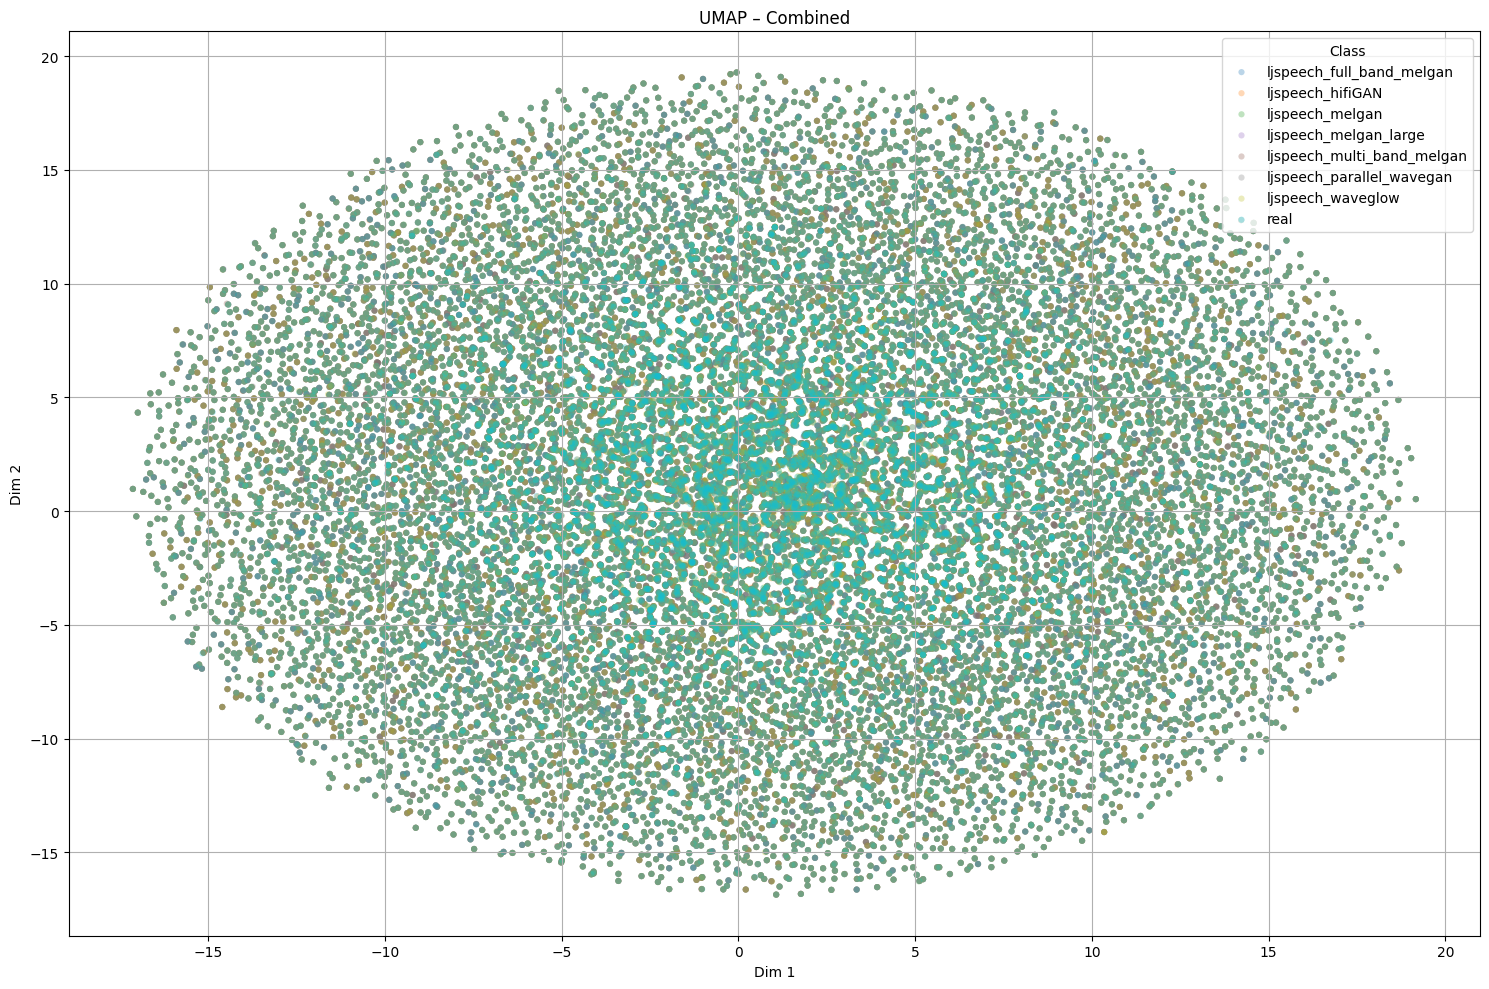

UMAP:  33%|███▎      | 1/3 [14:46<29:32, 886.02s/it]/home/ml/Documents/myenv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/tmp/ipykernel_2964398/4099083783.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


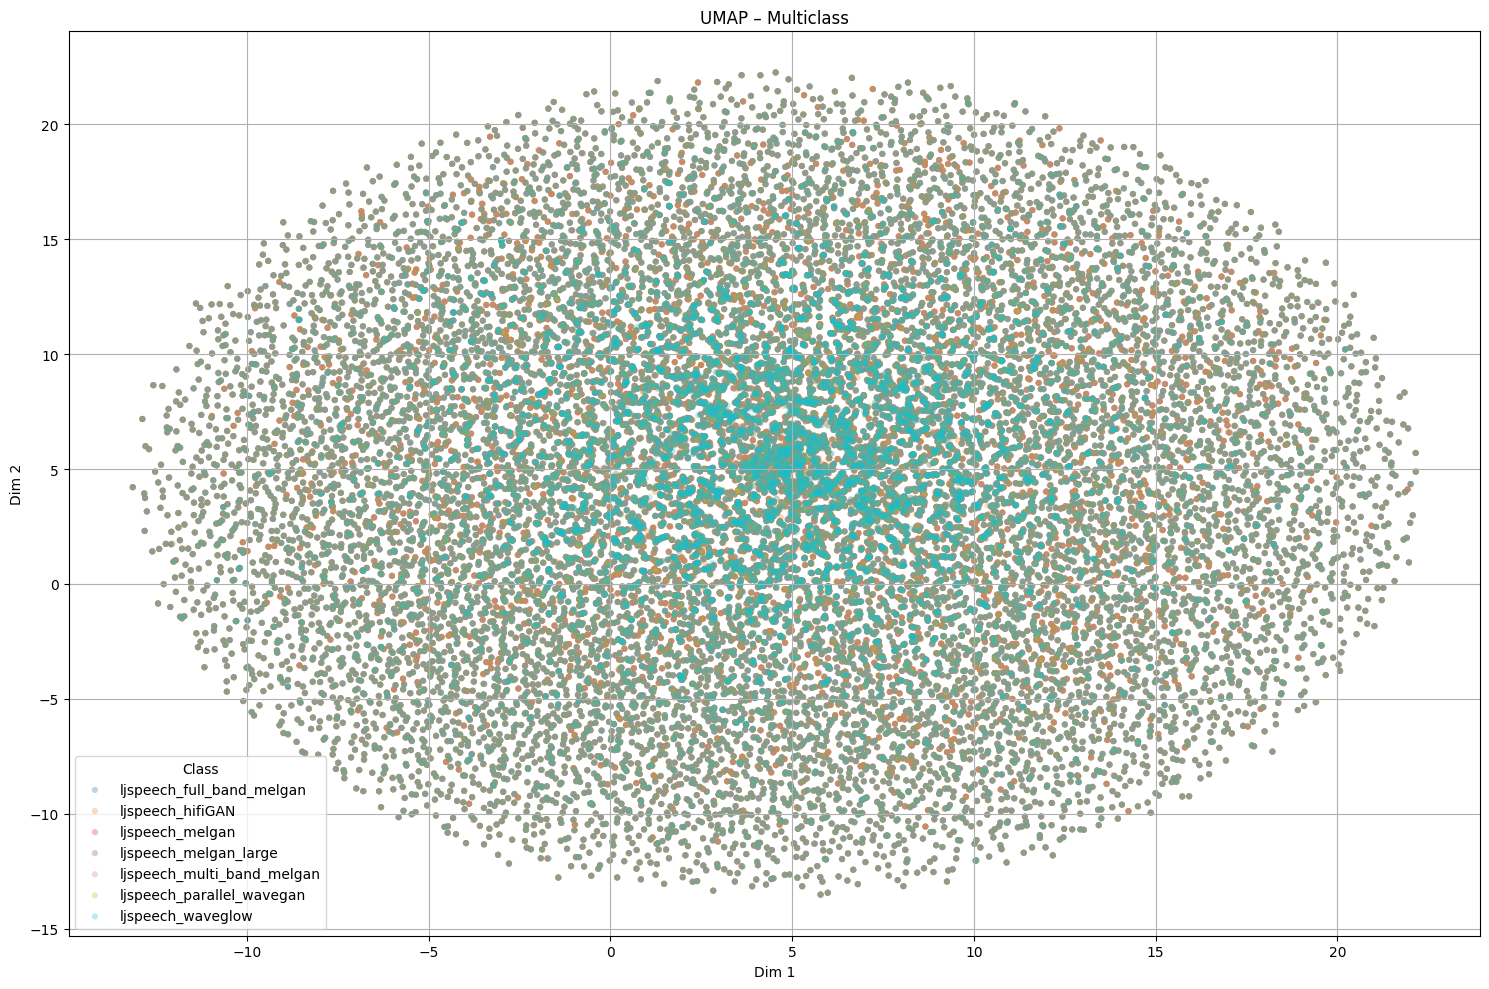

UMAP:  67%|██████▋   | 2/3 [23:45<11:22, 682.04s/it]/tmp/ipykernel_2964398/4099083783.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


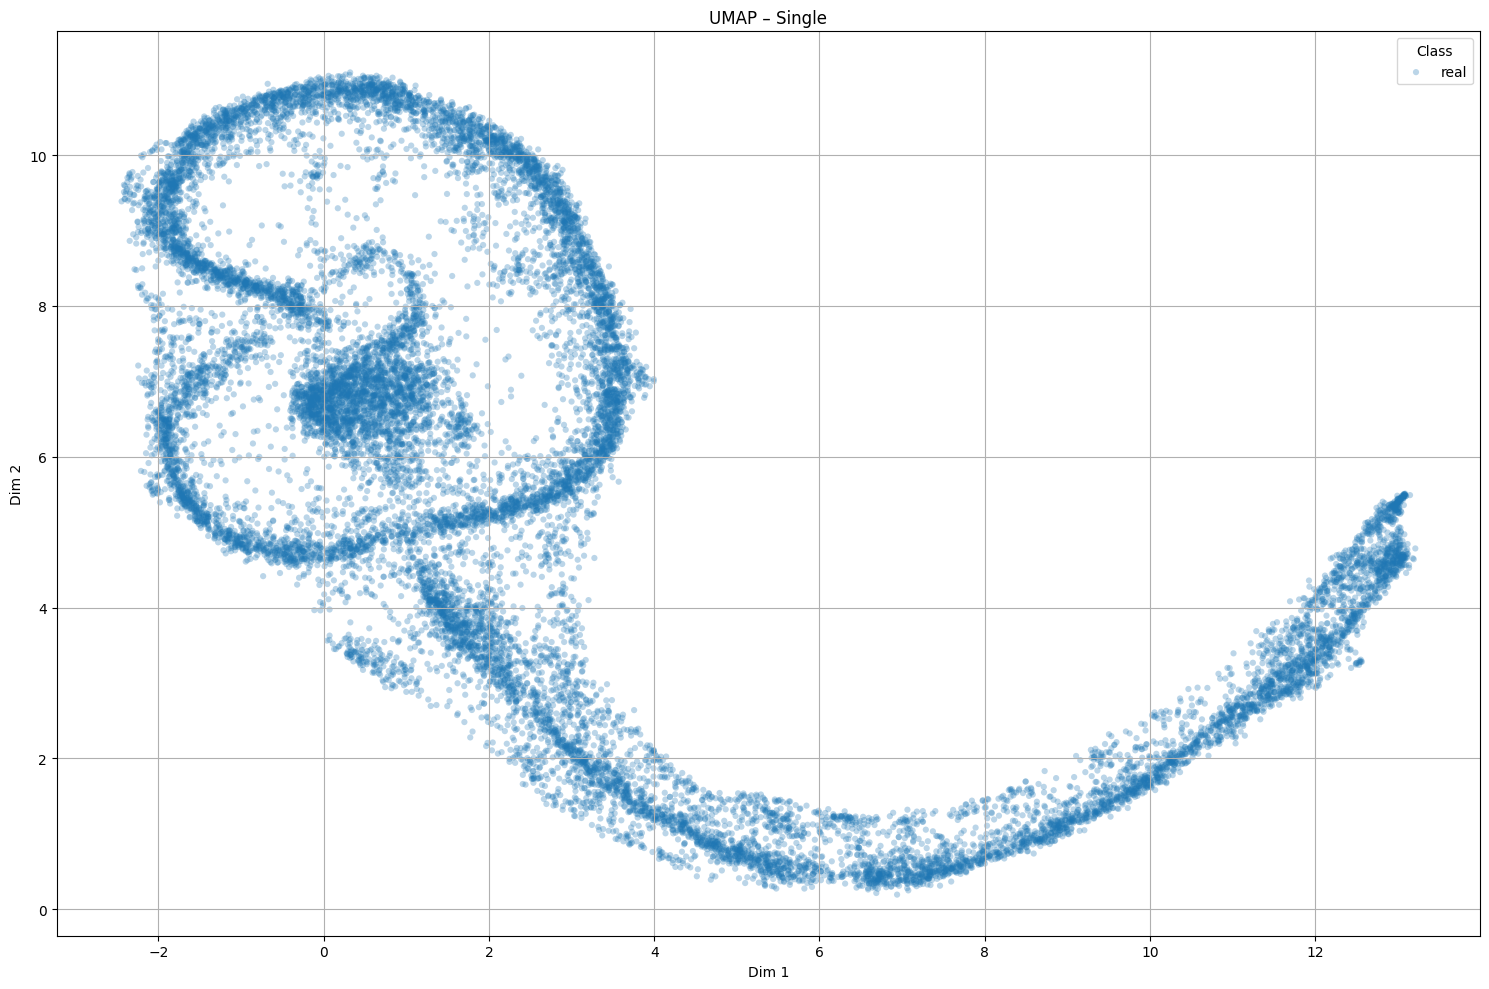

UMAP: 100%|██████████| 3/3 [24:20<00:00, 486.79s/it]


In [2]:
um = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)
for name, (X, y, ln) in tqdm({
    "Combined":   (X_comb,   y_comb,   label_names_comb),
    "Multiclass": (X_multi,  y_multi,  label_names_multi),
    "Single":     (X_single, y_single, label_names_single),
}.items(), desc="UMAP"):
    X2 = um.fit_transform(X)
    plot_2d(X2, y, ln, f"UMAP – {name}")


In [ ]:
# ── 4) Isomap ───────────────────────────────────────────────────
iso = Isomap(n_components=2, n_neighbors=10)
for name, (X, y, ln) in tqdm({
    "Combined":   (X_comb,   y_comb,   label_names_comb),
    "Multiclass": (X_multi,  y_multi,  label_names_multi),
    "Single":     (X_single, y_single, label_names_single),
}.items(), desc="Isomap"):
    X2 = iso.fit_transform(X)
    plot_2d(X2, y, ln, f"Isomap – {name}")


Isomap:   0%|          | 0/3 [00:00<?, ?it/s]/home/ml/Documents/myenv/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 51 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/ml/Documents/myenv/lib/python3.12/site-packages/scipy/sparse/_index.py:155: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/ml/Documents/myenv/lib/python3.12/site-packages/scipy/sparse/_index.py:155: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/ml/Documents/myenv/lib/python3.12/site-packages/scipy/sparse/_index.py:155: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil 

In [ ]:
# ── 5) Autoencoder ───────────────────────────────────────────────
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, bottleneck_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        x_rec = self.decoder(z)
        return x_rec, z

def train_ae(X, n_epochs=30, batch_size=128):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_tensor = torch.from_numpy(X).float()
    ds_ae = TensorDataset(X_tensor)
    loader_ae = DataLoader(ds_ae, batch_size=batch_size, shuffle=True)

    ae = Autoencoder(input_dim=X.shape[1]).to(device)
    opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in tqdm(range(1, n_epochs+1), desc="AE Training"):
        total = 0.0
        for batch, in loader_ae:
            batch = batch.to(device)
            opt.zero_grad()
            rec, _ = ae(batch)
            loss = criterion(rec, batch)
            loss.backward()
            opt.step()
            total += loss.item() * batch.size(0)

    ae.eval()
    with torch.no_grad():
        codes = ae.encoder(torch.from_numpy(X).float().to(device))
    return codes.cpu().numpy()

for name, (X, y, ln) in tqdm({
    "Combined":   (X_comb,   y_comb,   label_names_comb),
    "Multiclass": (X_multi,  y_multi,  label_names_multi),
    "Single":     (X_single, y_single, label_names_single),
}.items(), desc="Autoencoder"):
    Z = train_ae(X)
    plot_2d(Z, y, ln, f"Autoencoder – {name}")


In [ ]:
um = umap.UMAP(
    n_components=10,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)
for name, (X, y, ln) in tqdm({
    "Combined":   (X_comb,   y_comb,   label_names_comb),
    "Multiclass": (X_multi,  y_multi,  label_names_multi),
    "Single":     (X_single, y_single, label_names_single),
}.items(), desc="UMAP"):
    X2 = um.fit_transform(X)
    plot_2d(X2, y, ln, f"UMAP – {name}")
